In [18]:
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import tqdm
import time
import os
import wandb
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from collections import OrderedDict
from external_utils import format_time
from utils.data_preprocessing import preprocess_dataset_get_dataset, generate_dataset_from_loader,preprocess_dataset_get_data_loader
from structure.dlgn_conv_config_structure import DatasetConfig
import numpy as np
import csv
from conv4_models import get_model_instance_from_dataset, get_img_size
from utils.forward_visualization_helpers import merge_operations_in_modules, apply_input_on_conv_matrix, merge_layers_operations_in_modules


In [19]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
dataset = 'mnist'
data_config = DatasetConfig(
                dataset, is_normalize_data=True, valid_split_size=0.1, batch_size=128, list_of_classes=None,custom_dataset_path=None)

trainloader, _, testloader = preprocess_dataset_get_data_loader(
                data_config, "dnn", verbose=1, dataset_folder="./Datasets/", is_split_validation=False)

np.max(filtered_X_train) 255.0


filtered_X_train  1.0 0.0
filtered_X_test  1.0 0.0


In [22]:
tst = next(iter(trainloader))
tst[0].size()

torch.Size([128, 1, 28, 28])

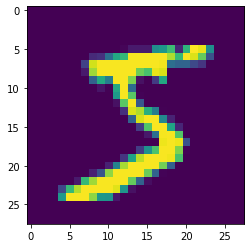

In [23]:
img = tst[0][0]
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [24]:
def plot_margin_stats_together(std_margin_arr,pgd_margin_arr,std_path,pgd_path):
    width = 0.5
    hw=0.2
    # set up the figure and axes
    fig, axs = plt.subplots(2,1,figsize=(50, 50))

    xs = np.arange(std_margin_arr.shape[0])
    std_margin_arr = np.abs(std_margin_arr)
    pgd_margin_arr = np.abs(pgd_margin_arr)

    # Median plots
    axs[0].bar(xs-hw, np.median(std_margin_arr,axis=1),label="STD-TR",width = width)
    axs[0].bar(xs+hw, np.median(pgd_margin_arr,axis=1),label="PGD-AT",width = width)
    axs[0].legend()
    axs[0].set_title('Median distance from hyperplane STD-TR vs PGD-AT')
    axs[0].set_xlabel("Gate Index")

    # Max plots
    axs[1].bar(xs-hw, np.max(std_margin_arr,axis=1),label="STD-TR",width = width)
    axs[1].bar(xs+hw, np.max(pgd_margin_arr,axis=1),label="PGD-AT",width = width)
    axs[1].legend()
    axs[1].set_title('Max distance from hyperplane STD-TR vs PGD-AT')
    axs[1].set_xlabel("Gate Index")

    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/std_vs_pgd_distance_from_HP.jpg")
    plt.show()

In [25]:
def plot_margin_per_gate(std_margin_arr,pgd_margin_arr,std_path,pgd_path,gateindx_start,gate_indx_end):
    # set up the figure and axes
    fig, axs = plt.subplots((gate_indx_end-gateindx_start+1), 2,figsize=(75, 25))

    xs = np.arange(std_margin_arr.shape[0])

    std_margin_arr = np.abs(std_margin_arr)
    pgd_margin_arr = np.abs(pgd_margin_arr)
    ind = 0
    for gind in range(gateindx_start,gate_indx_end+1):
        axs[ind, 0].hist(std_margin_arr[gind])
        axs[ind, 0].set_title('Gate:{} Histogram of distance from HP STD-TR'.format(gind))
        axs[ind, 0].set_xlabel("Distance from HP")
        axs[ind, 0].set_ylabel("Frequency")

        axs[ind, 1].hist(pgd_margin_arr[gind])
        axs[ind, 1].set_title('Gate:{} Histogram of distance from HP PGD-AT'.format(gind))
        axs[ind, 1].set_xlabel("Distance from HP")
        axs[ind, 1].set_ylabel("Frequency")
        ind+=1
        

    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/gate_wise_histogram_pgd_vs_std_gind_{}_{}.jpg".format(gateindx_start,gate_indx_end))

    plt.show()

In [26]:
def plot_margin_stats(std_margin_arr,pgd_margin_arr,std_path,pgd_path):
    # set up the figure and axes
    fig, axs = plt.subplots(2, 2,figsize=(25, 25),sharey='row')

    xs = np.arange(std_margin_arr.shape[0])

    std_margin_arr = np.abs(std_margin_arr)
    pgd_margin_arr = np.abs(pgd_margin_arr)
    
    # Median plots
    medind = 0
    axs[medind, 0].bar(xs, np.median(std_margin_arr,axis=1))
    axs[medind, 0].set_title('Median distance from HP STD-TR')
    axs[medind, 0].set_xlabel("Gate Index")

    axs[medind, 1].bar(xs, np.median(pgd_margin_arr,axis=1))
    axs[medind, 1].set_title('Median distance from HP PGD-AT')
    axs[medind, 1].set_xlabel("Gate Index")

    # Max plots
    maxind = 1
    axs[maxind, 0].bar(xs, np.max(std_margin_arr,axis=1))
    axs[maxind, 0].set_title('Max distance from HP STD-TR')
    axs[maxind, 0].set_xlabel("Gate Index")

    axs[maxind, 1].bar(xs, np.max(pgd_margin_arr,axis=1))
    axs[maxind, 1].set_title('Max distance from HP PGD-AT')
    axs[maxind, 1].set_xlabel("Gate Index")

    save_folder = get_margin_folder(pgd_path)+"/"+get_margin_folder(std_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig(save_folder+"/distance_from_HP.jpg")

    plt.show()

In [27]:
def generate_preacts_all_examples(model_arch_type,mpath,trainloader):
    fc_width = 128
    fc_depth = 4
    nodes_in_each_layer_list = [fc_width] * fc_depth
    model = get_model_instance_from_dataset(dataset,
                                                  model_arch_type, seed=2022, num_classes=10, nodes_in_each_layer_list=nodes_in_each_layer_list)
    model.load_state_dict(torch.load(mpath).state_dict())
    model = model.to(device)
    model.eval()
    
    outcapturer = OrderedDict()
    dummy_input = torch.rand(get_img_size(dataset)).unsqueeze(0)
    dummy_input = dummy_input.to(device)
    
    conv_matrix_operations_in_each_layer, conv_bias_operations_in_each_layer, channel_outs_size_in_each_layer = model.exact_forward_vis(dummy_input)

    for key,cur_m in model.get_gate_layers_ordered_dict().items():
        if isinstance(cur_m, nn.Linear):
            print(key,cur_m.weight.size(),cur_m.bias.size())
            outcapturer[key] = SaveFeatures(cur_m)

    overall_margin = None
    loader = tqdm.tqdm(trainloader, desc='Generating Margin Histogram')
    for batch_idx, data in enumerate(loader, 0):
        (X, y) = data
        X, y = X.cuda(), y.cuda()
        model(X)

        cur_batch_margins = None
        for key,cur_m in model.get_gate_layers_ordered_dict().items():
            cur_eff_w_norm = torch.norm(conv_matrix_operations_in_each_layer[key],p=2,dim=1).unsqueeze(0)
            cur_margin = outcapturer[key].features/cur_eff_w_norm
            if(cur_batch_margins is None):
                cur_batch_margins = cur_margin.T
            else:
                cur_batch_margins = torch.vstack([cur_batch_margins,cur_margin.T])
        
        if(overall_margin is None):
            overall_margin = cur_batch_margins.detach().cpu()
        else:
            overall_margin = torch.hstack([overall_margin.detach().cpu(),cur_batch_margins.detach().cpu()])
    print("overall_margin ",overall_margin.size())
    
    return overall_margin.numpy()
            

In [28]:
tmpmodel = torch.load("root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt")
total_params = 0
for param in tmpmodel.parameters():
    total_params += param.numel()
print(total_params)
print(tmpmodel)

553226
SF_DLGN_FC_Network(
  (gating_network): SF_DLGN_FC_Gating_Network(
    (list_of_modules): ModuleList(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Linear(in_features=784, out_features=128, bias=True)
      (2): Linear(in_features=784, out_features=128, bias=True)
      (3): Linear(in_features=784, out_features=128, bias=True)
    )
  )
  (value_network): ALLONES_FC_Value_Network(
    (list_of_modules): ModuleList(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (output_layer): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [29]:
tmpmodel = torch.load("root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dlgn_W_128_D_4_dir.pt")
total_params = 0
for param in tmpmodel.parameters():
    total_params += param.numel()
print(total_params)
print(tmpmodel)

301322
DLGN_FC_Network(
  (gating_network): DLGN_FC_Gating_Network(
    (list_of_modules): ModuleList(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (value_network): ALLONES_FC_Value_Network(
    (list_of_modules): ModuleList(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (output_layer): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [30]:
tmpmodel = torch.load("root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_dnn_W_128_D_4_dir.pt")
total_params = 0
for param in tmpmodel.parameters():
    total_params += param.numel()
print(total_params)
print(tmpmodel)

151306
Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512



In [31]:
pgdat_path = "root/model/save/mnist/adversarial_training/MT_fc_sf_dlgn_W_128_D_4_ET_ADV_TRAINING/ST_2022/fast_adv_attack_type_PGD/adv_type_PGD/EPS_0.3/batch_size_64/eps_stp_size_0.01/adv_steps_40/update_on_all/R_init_True/norm_inf/use_ytrue_True/adv_model_dir.pt"
pgd_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",pgdat_path,trainloader)
pgd_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Margin Histogram:   0%|          | 1/469 [00:00<03:04,  2.54it/s]

Generating Margin Histogram: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s] 

overall_margin  torch.Size([512, 60000])


(512, 60000)

In [32]:
std_path = "root/model/save/mnist/CLEAN_TRAINING/ST_2022/fc_sf_dlgn_W_128_D_4_dir.pt"
std_sf_preact = generate_preacts_all_examples("fc_sf_dlgn",std_path,trainloader)
std_sf_preact.shape

self.gating_network Gating network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480

Gating net params: 401920
self.value_network Value network  
 module_list:Linear(in_features=784, out_features=128, bias=True) 
 Params in module is:100480
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512
Linear(in_features=128, out_features=128, bias=True) 
 Params in module is:16512

Value net params: 151306
current_tensor_size  torch.Size([1, 784])
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
difference_in_output  tensor(0., device='cuda:0')
diff

Generating Margin Histogram:   0%|          | 0/469 [00:00<?, ?it/s]

Generating Margin Histogram: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s] 

overall_margin  torch.Size([512, 60000])


(512, 60000)

In [33]:
np.mean(np.min(np.abs(std_sf_preact),axis=1))

3.978002e-05

In [34]:
np.mean(np.min(np.abs(pgd_sf_preact),axis=1))

0.0016619423

In [35]:
np.sum(np.where(np.abs(std_sf_preact) > 0.3,1,0))/np.prod(std_sf_preact.shape)

0.731519140625

In [36]:
np.sum(np.where(np.abs(pgd_sf_preact) > 0.3,1,0))/np.prod(pgd_sf_preact.shape)

0.8540430989583333

In [37]:
def get_margin_folder(model_path):
    return model_path.replace(".pt","/MARGIN_ANALYSIS/")

In [38]:
def save_margin_as_csv(preacts,model_path):
    preacts = preacts.T.tolist()
    save_folder=get_margin_folder(model_path)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    with open(save_folder+'/distance_from_HP.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(preacts)

In [39]:
# save_margin_as_csv(std_sf_preact,std_path)

In [40]:
# save_margin_as_csv(pgd_sf_preact,pgdat_path)

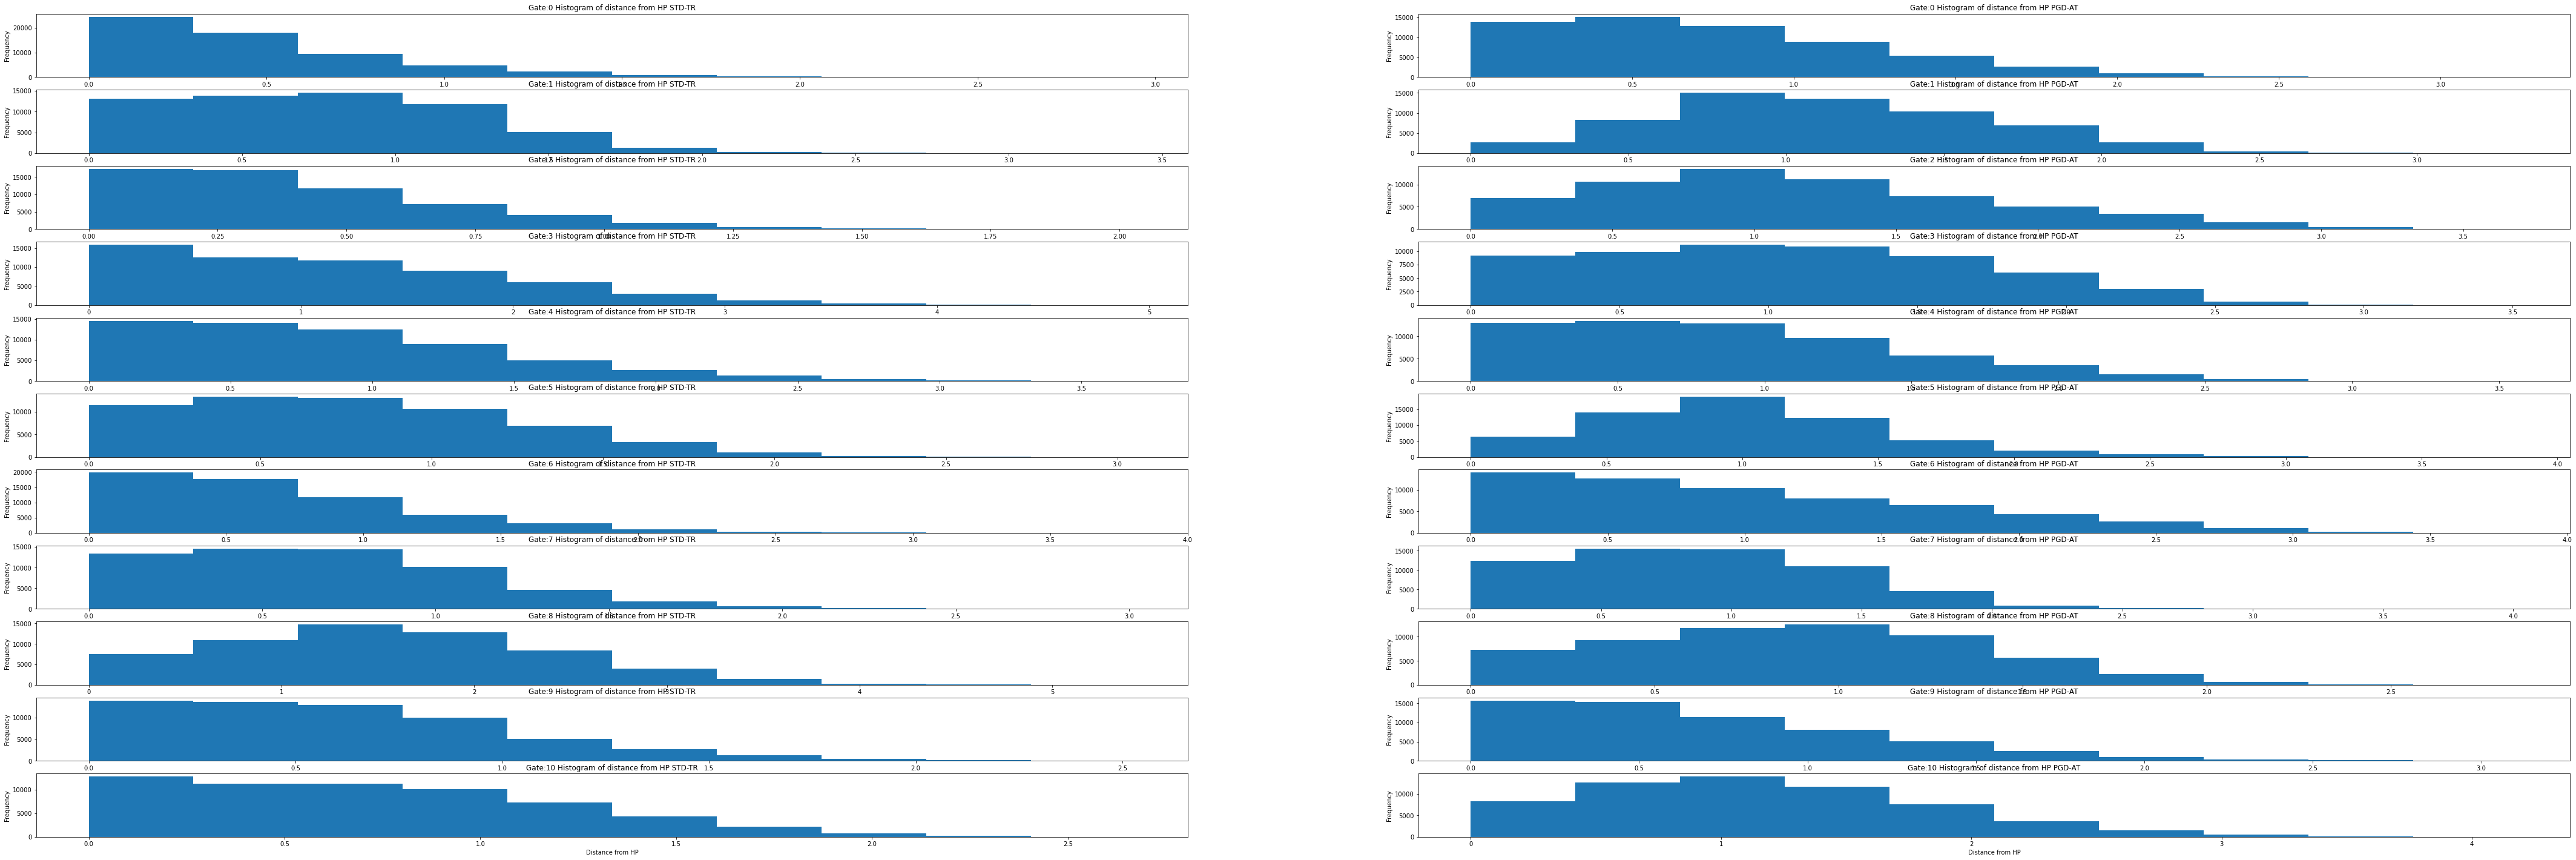

In [41]:
plot_margin_per_gate(std_sf_preact,pgd_sf_preact,std_path,pgdat_path,gateindx_start=0,gate_indx_end=10)

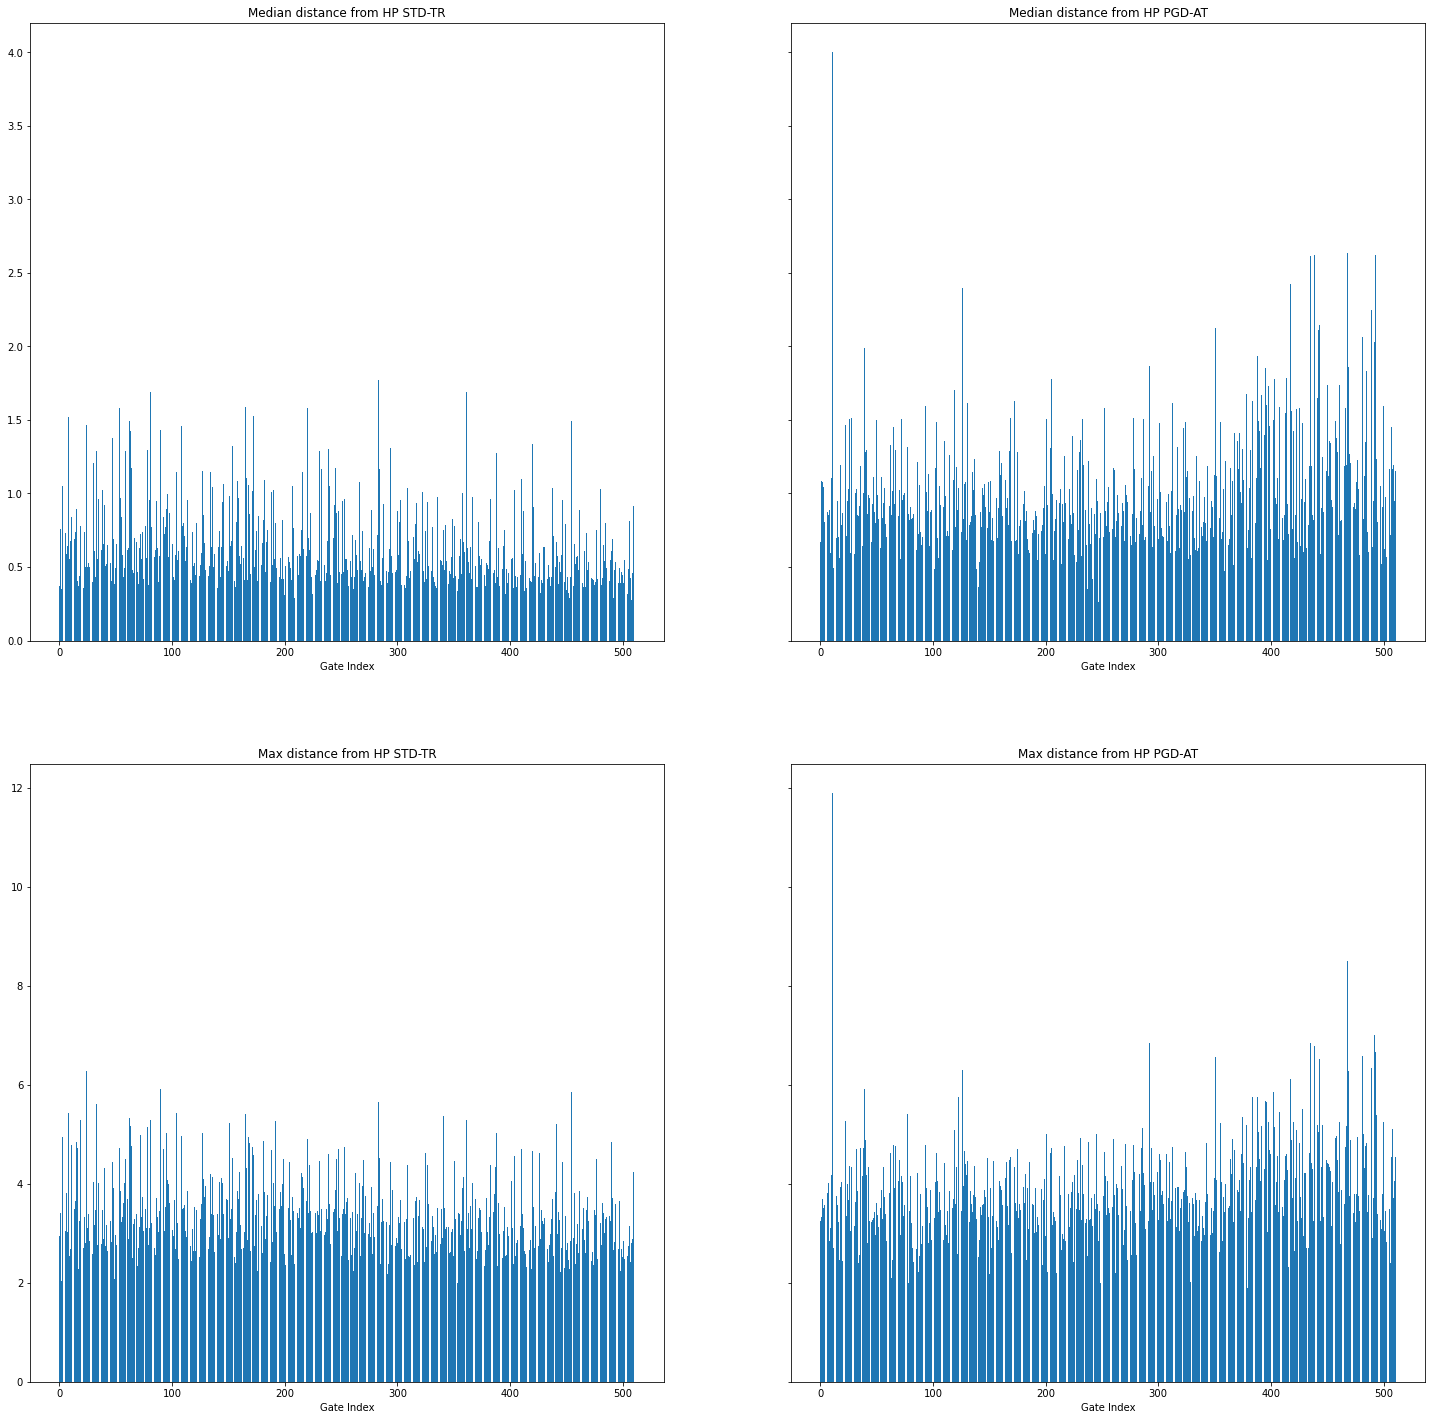

In [42]:
plot_margin_stats(std_sf_preact,pgd_sf_preact,std_path,pgdat_path)

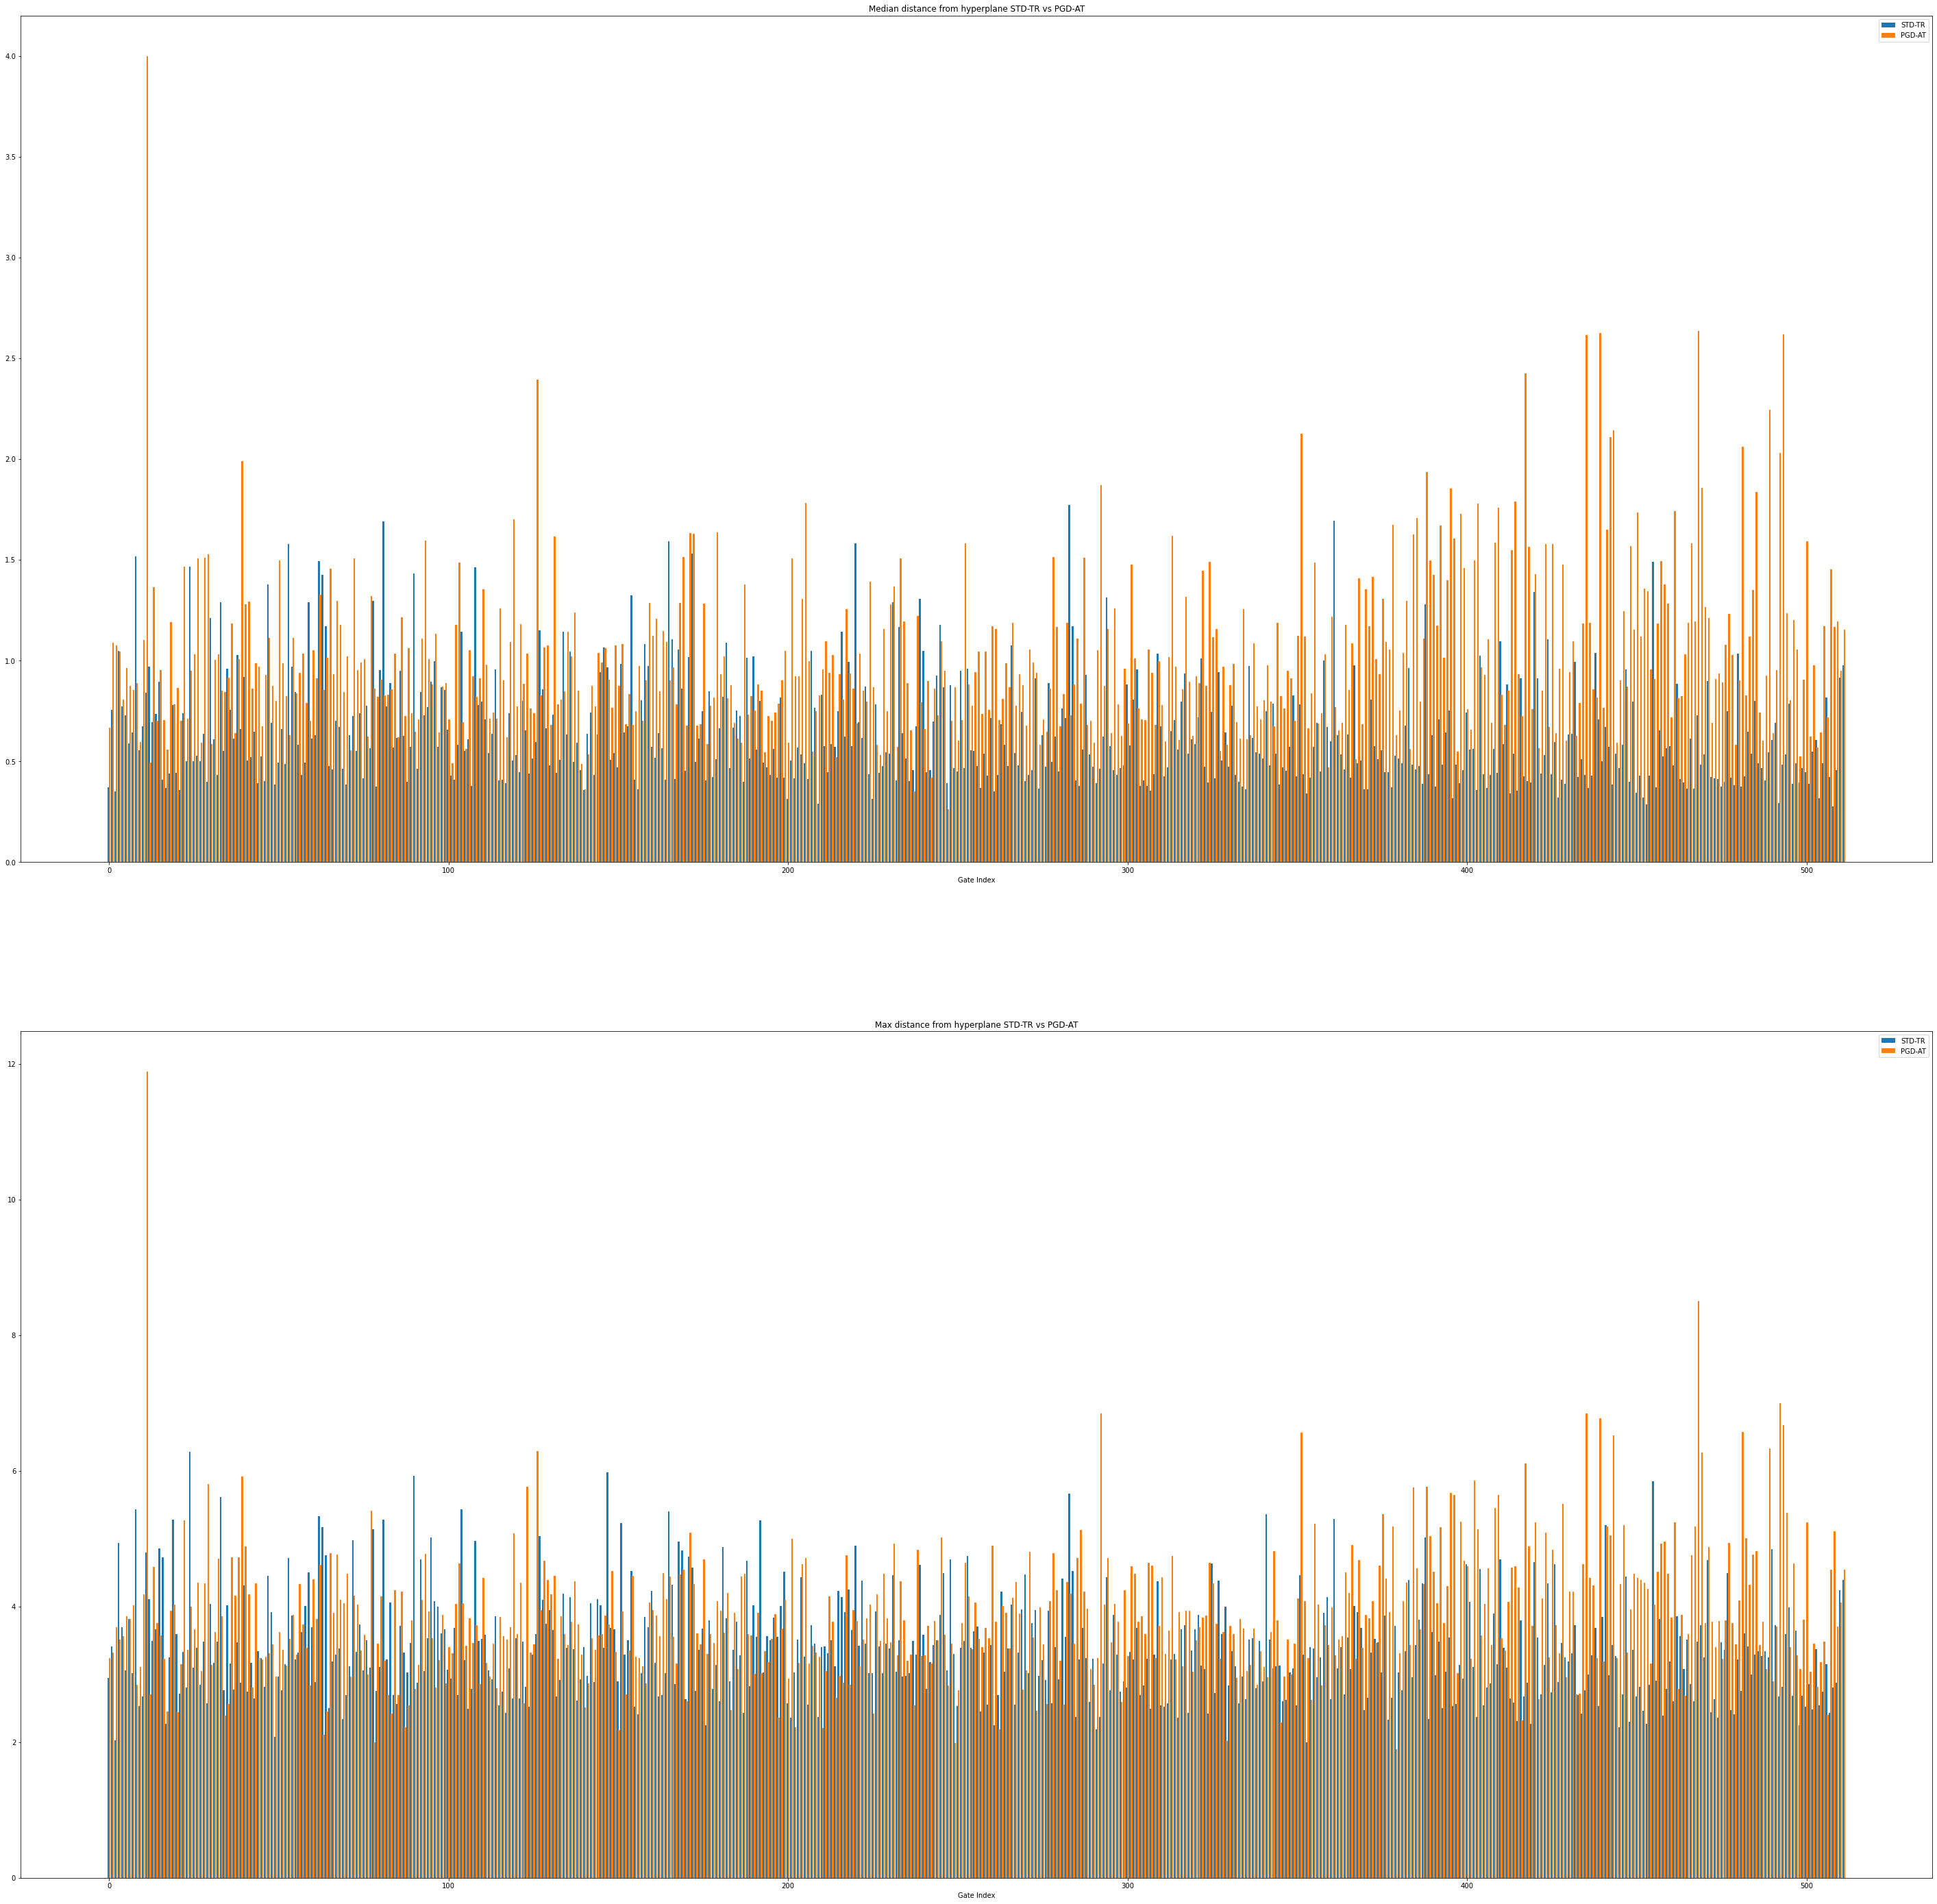

In [43]:
plot_margin_stats_together(std_sf_preact,pgd_sf_preact,std_path,pgdat_path)

x:(20,), y:(20,), bottom:(20,), width:1, depth:1


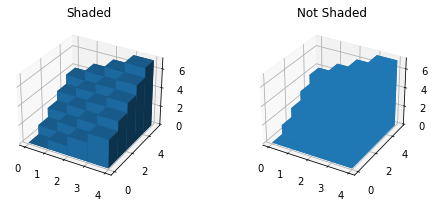

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# set up the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1
print("x:{}, y:{}, bottom:{}, width:{}, depth:{}".format(x.shape, y.shape, bottom.shape, width, depth))
ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

NameError: name 'pgd_sf_margin' is not defined

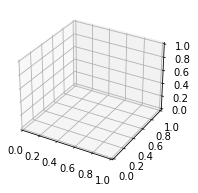

In [45]:
def function(x, y):
    return pgd_sf_margin[x][y]

# set up the figure and axes
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121, projection='3d')
# ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(pgd_sf_margin.shape[0])
_y = np.arange(pgd_sf_margin.shape[1])
_xx, _yy = np.meshgrid(_x, _y)
Z = function(x, y)
 
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
 
ax.plot_surface(x, y, Z, cmap='cool', alpha=0.8)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

plt.show()